## Implementar el algoritmo White Patch para librarnos de las diferencias de color de iluminación.

Primero, vamos a observar las imágenes que debemos modificar:

In [19]:
%matplotlib inline

import numpy as np
import cv2 as cv
import supervision as sv
import os

In [20]:
# Ruta a la carpeta con imágenes
folder = 'material/white_patch'

# Obtener todos los nombres de archivo en la carpeta
images = [f for f in os.listdir(folder) if f.endswith(('.png', '.jpg', '.jpeg'))]
images.sort()

In [21]:
images_grid = []
titles = []
for i, name in enumerate(images):
    path = os.path.join(folder, name)
    img = cv.imread(path)
    images_grid.append(img)
    titles.append(name)

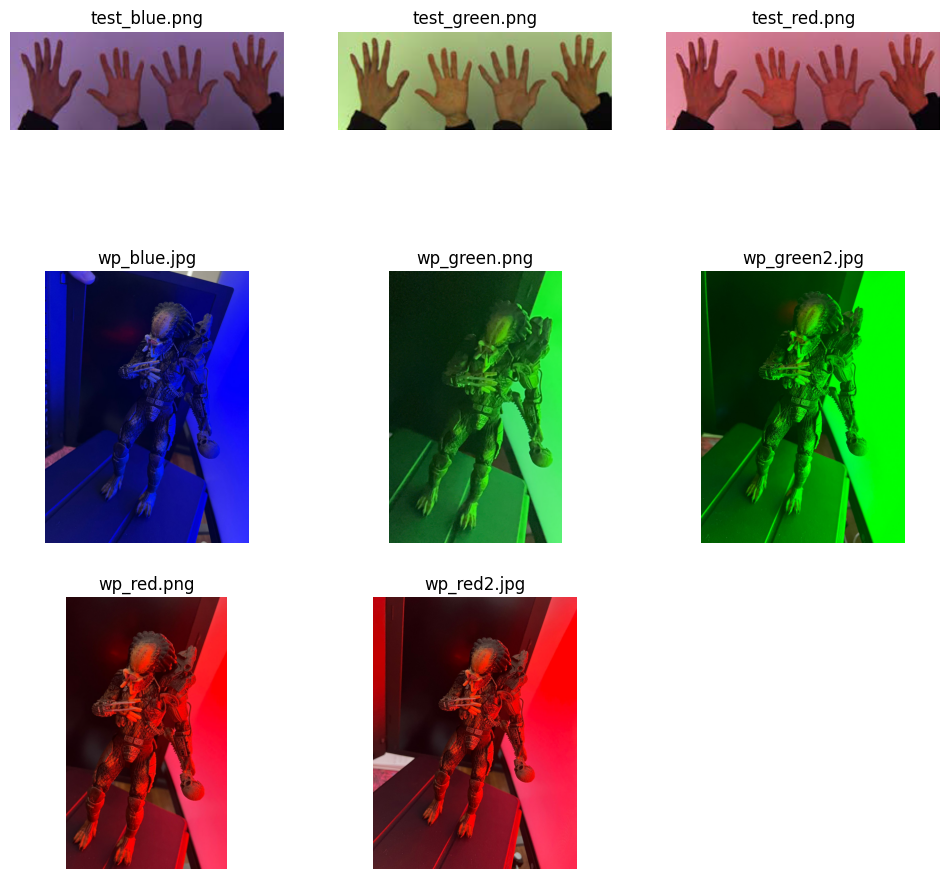

In [22]:
sv.plot_images_grid(
    images=images_grid,
    titles=titles,
    grid_size=(3, 3)
)

In [23]:
output_folder = 'material/white_patch/solutions'

In [24]:
def apply_white_patch(image_name):
    path = os.path.join(folder, image_name)
    image = cv.imread(path)

    # Separar canales BGR
    B, G, R = cv.split(image)

    # Obtener máximos por canal
    R = R.astype(np.float32)
    G = G.astype(np.float32)
    B = B.astype(np.float32)
    
    # Obtener máximos por canal
    R_max = R.max()
    G_max = G.max()
    B_max = B.max()
    
    # Evitar división por cero, aunque esto no debería darse. Indicaría que el canal completo está en 0
    R_max = R_max if R_max != 0 else 1
    G_max = G_max if G_max != 0 else 1
    B_max = B_max if B_max != 0 else 1
    
    # Operación de normalización
    R_norm = np.round(255 * R / R_max).astype(np.uint8)
    G_norm = np.round(255 * G / G_max).astype(np.uint8)
    B_norm = np.round(255 * B / B_max).astype(np.uint8)

    # Reconstruir imagen
    img_norm = cv.merge((B_norm, G_norm, R_norm))

    # Imprimir info
    print(f"{image_name}: Rmax={R_max}, Gmax={G_max}, Bmax={B_max}")

    output_image_name = 'fixed_' + image_name
    save_path = os.path.join(output_folder, output_image_name)
    cv.imwrite(save_path, img_norm)
    
    return output_image_name

In [25]:
fixed_images = []
for i, name in enumerate(images):
    fixed_images.append(apply_white_patch(name))

test_blue.png: Rmax=165.0, Gmax=138.0, Bmax=200.0
test_green.png: Rmax=210.0, Gmax=250.0, Bmax=171.0
test_red.png: Rmax=247.0, Gmax=157.0, Bmax=175.0
wp_blue.jpg: Rmax=255.0, Gmax=255.0, Bmax=255.0
wp_green.png: Rmax=126.0, Gmax=252.0, Bmax=155.0
wp_green2.jpg: Rmax=170.0, Gmax=255.0, Bmax=172.0
wp_red.png: Rmax=255.0, Gmax=134.0, Bmax=122.0
wp_red2.jpg: Rmax=255.0, Gmax=201.0, Bmax=203.0


In [26]:
output_images_grid = []
output_titles = []
for i, name in enumerate(fixed_images):
    path = os.path.join(output_folder, name)
    img = cv.imread(path)
    output_images_grid.append(img)
    output_titles.append(name)

Podemos observar que se resuelve bastante bien el problema del iluminado en las imágenes de las manos, obteniendo para los 3 casos un a imagen en la que ya prácticamente no se nota una iluminación con un color en particular, pero las imágenes del alien no presentan prácticamente mejoras, y esto se debe a los altos valores máximos en ciertos canales para estas imágenes. Por tanto, amerita aplicar un percentil para mejorar la corrección de la iluminación.

In [27]:
def apply_improved_white_patch(image_name, percentile=95):
    path = os.path.join(folder, image_name)
    image = cv.imread(path)

    # Separar canales BGR
    B, G, R = cv.split(image)

    # Convertir a float para operaciones precisas
    R = R.astype(np.float32)
    G = G.astype(np.float32)
    B = B.astype(np.float32)

    # Calcular percentil por canal
    R_ref = np.percentile(R, percentile)
    G_ref = np.percentile(G, percentile)
    B_ref = np.percentile(B, percentile)

    # Evitar división por cero
    R_ref = R_ref if R_ref != 0 else 1
    G_ref = G_ref if G_ref != 0 else 1
    B_ref = B_ref if B_ref != 0 else 1

    # Normalización usando el percentil como referencia
    R_norm = np.round(255 * R / R_ref).clip(0, 255).astype(np.uint8)
    G_norm = np.round(255 * G / G_ref).clip(0, 255).astype(np.uint8)
    B_norm = np.round(255 * B / B_ref).clip(0, 255).astype(np.uint8)

    # Reconstruir imagen
    img_norm = cv.merge((B_norm, G_norm, R_norm))

    # Imprimir info
    print(f"{image_name}: R{percentile}={R_ref:.2f}, G{percentile}={G_ref:.2f}, B{percentile}={B_ref:.2f}")

    # Guardar imagen
    output_image_name = f'fixed_{image_name}'
    save_path = os.path.join(output_folder, output_image_name)
    cv.imwrite(save_path, img_norm)

    return output_image_name

In [33]:
def process_and_plot_white_patch(images, percentile=95, grid_size=(3, 3)):
    # Aplicar white patch a cada imagen
    fixed_images = [apply_improved_white_patch(name, percentile=percentile) for name in images]

    # Cargar las imágenes corregidas
    output_images_grid = []
    output_titles = []
    for name in fixed_images:
        path = os.path.join(output_folder, name)
        img = cv.imread(path)
        output_images_grid.append(img)
        output_titles.append(name)

    # Mostrar grilla
    return sv.plot_images_grid(
        images=output_images_grid,
        titles=output_titles,
        grid_size=grid_size
    )

test_blue.png: R90=140.00, G90=107.00, B90=159.00
test_green.png: R90=176.00, G90=201.00, B90=134.00
test_red.png: R90=209.00, G90=124.00, B90=145.00
wp_blue.jpg: R90=44.00, G90=41.00, B90=245.00
wp_green.png: R90=64.00, G90=233.00, B90=80.00
wp_green2.jpg: R90=9.00, G90=254.00, B90=9.00
wp_red.png: R90=253.00, G90=49.00, B90=65.00
wp_red2.jpg: R90=254.00, G90=49.00, B90=77.00


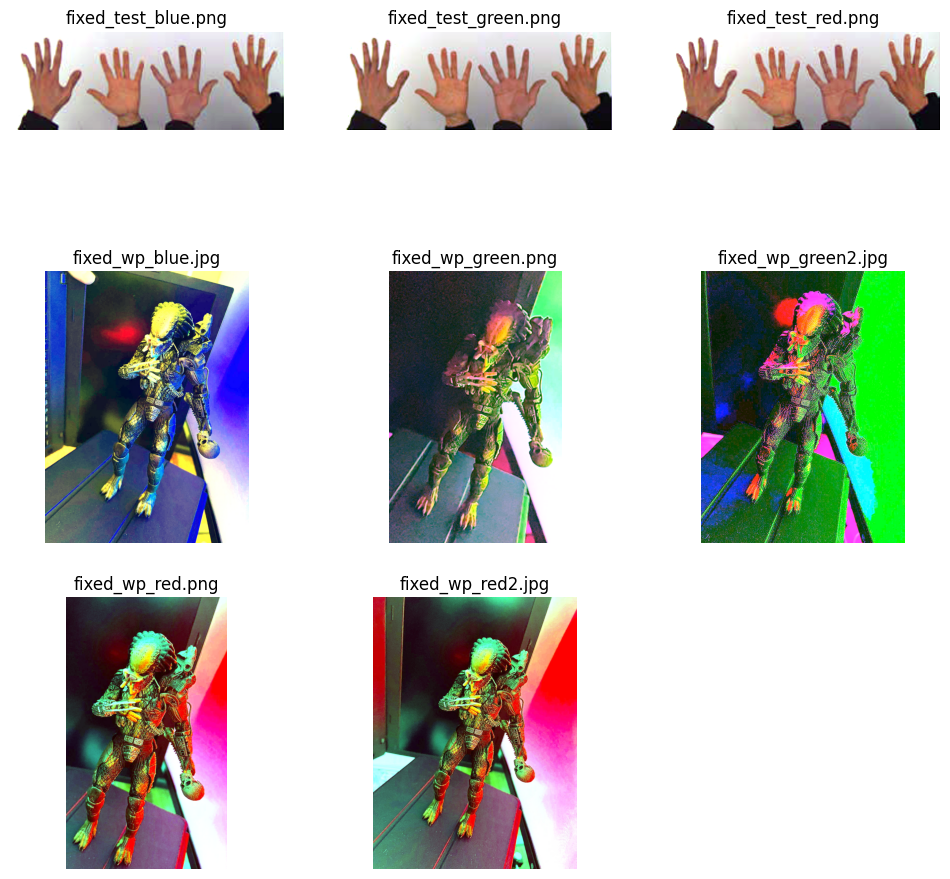

In [34]:
process_and_plot_white_patch(images, percentile=90)

test_blue.png: R95=148.00, G95=116.00, B95=173.00
test_green.png: R95=186.00, G95=218.00, B95=144.00
test_red.png: R95=223.00, G95=136.00, B95=158.00
wp_blue.jpg: R95=56.00, G95=51.00, B95=252.00
wp_green.png: R95=80.00, G95=237.00, B95=113.00
wp_green2.jpg: R95=30.00, G95=255.00, B95=24.00
wp_red.png: R95=255.00, G95=58.00, B95=90.00
wp_red2.jpg: R95=255.00, G95=60.00, B95=90.00


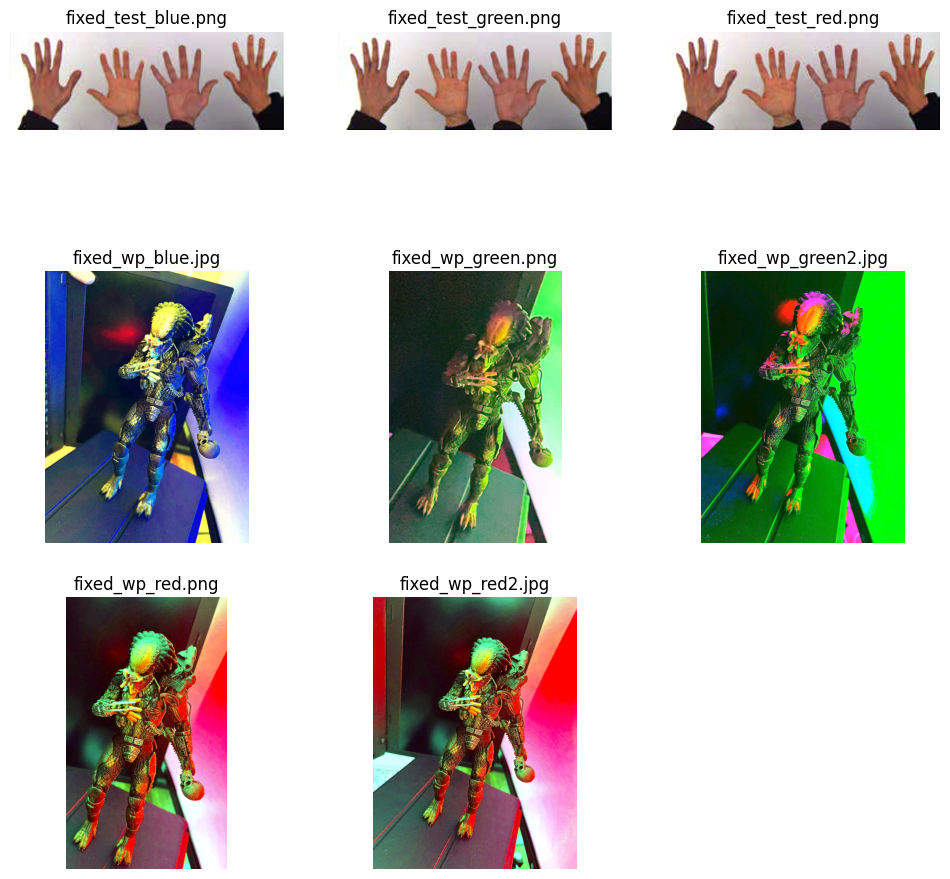

In [35]:
process_and_plot_white_patch(images, percentile=95)

test_blue.png: R97.5=151.00, G97.5=120.00, B97.5=176.00
test_green.png: R97.5=189.00, G97.5=225.00, B97.5=146.00
test_red.png: R97.5=227.00, G97.5=139.00, B97.5=160.00
wp_blue.jpg: R97.5=77.00, G97.5=65.00, B97.5=253.00
wp_green.png: R97.5=86.00, G97.5=241.00, B97.5=118.00
wp_green2.jpg: R97.5=53.00, G97.5=255.00, B97.5=39.00
wp_red.png: R97.5=255.00, G97.5=64.00, B97.5=98.00
wp_red2.jpg: R97.5=255.00, G97.5=70.00, B97.5=99.00


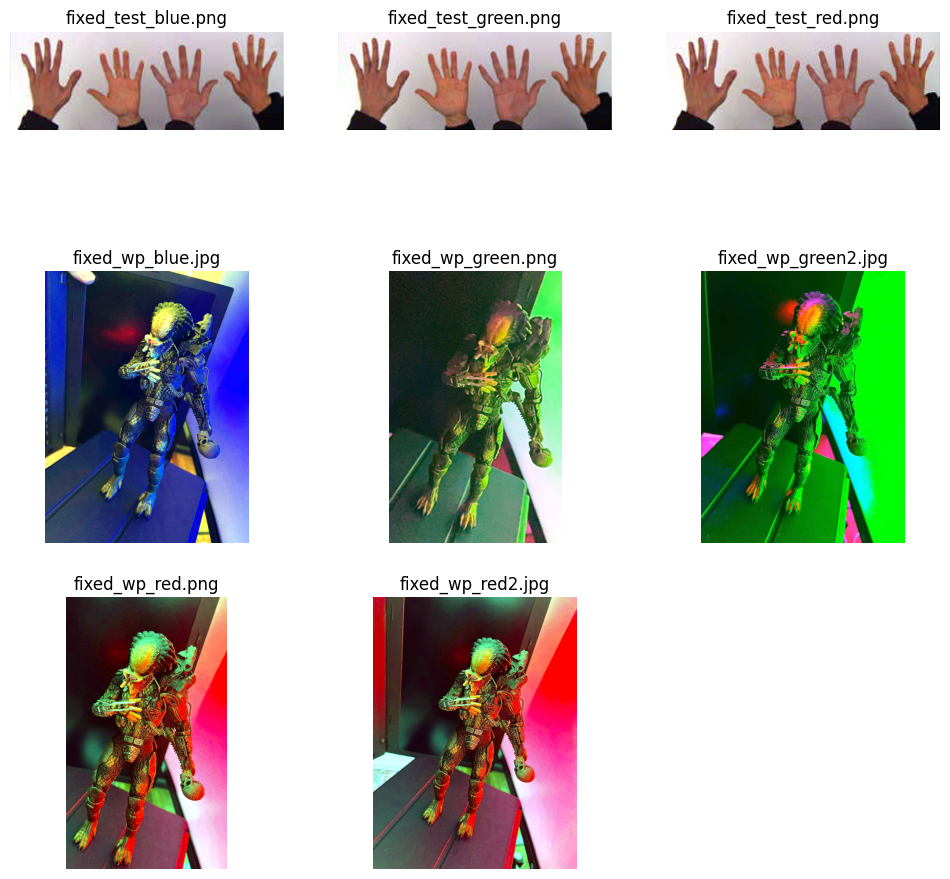

In [36]:
process_and_plot_white_patch(images, percentile=97.5)